In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from utils import *

In [3]:
# for plotting
plt.rcParams.update({'font.size': 16})

In [4]:
exp_meta_data_dir = '../meta_data/exp'
exp_data_dir = '../processed_data/exp'

fig_dir = 'Figures/Figure_2'

# Load data from experiments

In [5]:
# Load meta data
manifest_path = os.path.join(exp_meta_data_dir, 'ecephys_cache_dir_10_31', "manifest.json")
#manifest_path = os.path.join(exp_meta_data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

## CSD

In [6]:
channels = cache.get_channels()
probes = cache.get_probes()

#### Loadpaths to CSD data

In [7]:
trial_window_start = -1.0
trial_window_end = 0.5


loadpaths_csd = sorted(glob(os.path.join(exp_data_dir, 'csd', 
            'trial_window_'+str(trial_window_start).replace('.','pnt')+\
             '_to_'+str(trial_window_end).replace('.','pnt')+'s', '*')))
loadpaths_lfp = sorted(glob(os.path.join(exp_data_dir, 'lfp', 'trial_window_'\
             +str(trial_window_start).replace('.','pnt')+\
             '_to_'+str(trial_window_end).replace('.','pnt')+'s', '*')))
    
len(loadpaths_csd)

53

#### Read CSD files

In [8]:
twoi_start = -0.0
twoi_end = 0.1

Fs = 1250 # Hz

session_ids = list() # all session ids
sessions_channels_vert_pos = dict()
sessions_csd_trial_avg = dict()
sessions_csd_all_trials = dict()
sessions_channel_ids_csd = dict()

for i, file_path in enumerate(loadpaths_csd):
    session_id = os.path.basename(file_path).split('_')[0]
    print('Session id: ', session_id)
    data = np.load(file_path, allow_pickle = True)
        
    session_ids.append(session_id)
        
    t = np.array(data[()]['csd_mean']['time_from_presentation_onset'])
    t_min = twoi_start; t_max = twoi_end
    mask = np.logical_and(t>=t_min, t<=t_max)
    t = t[mask]
    
    channels_vert_pos = data[()]['channel_vertical_pos']
    channels_vert_pos = channels_vert_pos[::-1]
    channels_vert_pos -= channels_vert_pos.max()
    sessions_channels_vert_pos[session_id] = channels_vert_pos
    
    mask_session = channels['ecephys_session_id'] == int(session_id)
    mask_structure = channels[mask_session]['ecephys_structure_acronym'] == 'VISp'
    dorsal_ventral_ccf_coordinate = channels[mask_session][mask_structure]['dorsal_ventral_ccf_coordinate']
    channel_ids_csd = data[()]['csd_mean'].channel.values
    dorsal_ventral_ccf_coordinate = -(dorsal_ventral_ccf_coordinate[channel_ids_csd]-dorsal_ventral_ccf_coordinate[channel_ids_csd].min())# higher dorsal-ventral value means more ventral
    
    if ~np.all(np.isnan(dorsal_ventral_ccf_coordinate)): # if all NaNs it means exact probe location not recovered
        csd_trial_avg = data[()]['csd_mean']
        csd_trial_avg = csd_trial_avg[:,mask]
        sessions_csd_trial_avg[session_id] = csd_trial_avg.values

        csd_all_trials = data[()]['csd']
        csd_all_trials = csd_all_trials[:,:,mask]
        sessions_csd_all_trials[session_id] = csd_all_trials.values
        
        sessions_channel_ids_csd[session_id] = channel_ids_csd

Session id:  715093703
Session id:  719161530
Session id:  721123822
Session id:  732592105
Session id:  737581020
Session id:  739448407
Session id:  742951821
Session id:  744228101
Session id:  746083955
Session id:  750332458
Session id:  750749662
Session id:  751348571
Session id:  754312389
Session id:  754829445
Session id:  755434585
Session id:  756029989
Session id:  757216464
Session id:  757970808
Session id:  758798717
Session id:  759883607
Session id:  760345702
Session id:  760693773
Session id:  761418226
Session id:  762120172
Session id:  762602078
Session id:  763673393
Session id:  766640955
Session id:  767871931
Session id:  768515987
Session id:  771160300
Session id:  771990200
Session id:  773418906
Session id:  774875821
Session id:  778240327
Session id:  778998620
Session id:  779839471
Session id:  781842082
Session id:  786091066
Session id:  787025148
Session id:  789848216
Session id:  791319847
Session id:  793224716
Session id:  794812542
Session id:

### Load channel depth data

In [9]:

#filename = 'cortical_depth_'+str(session_id)+'.csv'
#loadpath = os.path.join(exp_meta_data_dir, 'probes_cortical_depths', filename)
sessions_df_depth = dict()
loadpaths = sorted(glob(os.path.join(exp_meta_data_dir, 'probes_cortical_depths', '*')))
for loadpath in loadpaths:
    session_id = loadpath.split('/')[-1].split('.')[0].split('_')[-1]
    df_depth = pd.read_csv(loadpath, sep=' ')
    df_depth = df_depth.set_index('id')
    sessions_df_depth[session_id] = df_depth


### Remove faulty channels

In [10]:
structure = 'VISp'
sessions_channels_cort_depth = dict()

for session_id in sessions_df_depth.keys():
    df_depth = sessions_df_depth[session_id]
    mask_structure = df_depth.ecephys_structure_acronym == structure
    df_depth = df_depth[mask_structure]
    channels_cort_depth = df_depth.cortical_depth
        
    if session_id in sessions_channel_ids_csd.keys():
        print('Session ID: ', session_id)
        
        channel_ids_csd = sessions_channel_ids_csd[session_id]
    
        channels_cort_depth = channels_cort_depth[channel_ids_csd]      
        sessions_channels_cort_depth[session_id] = channels_cort_depth.values
        
print('\n ---------------------------------------------- \n')
sessions_channels_cort_depth_cleaned = dict()
for session_id, channels_cort_depth in sessions_channels_cort_depth.items():
    channels_cort_depth = channels_cort_depth[::-1]
    
    mask_nan = np.isnan(channels_cort_depth)
    
    channels_cort_depth_no_nan = channels_cort_depth[~mask_nan][::-1]
    
    if mask_nan.sum() > 0:
        print('Session ID: ', session_id, 'has NaN channels', channels_cort_depth, '\n', channels_cort_depth_no_nan, '\n', len(channels_cort_depth_no_nan))
        
    mask_zeros_after_1st_chan = channels_cort_depth_no_nan == 0
    
    if mask_zeros_after_1st_chan[1:].sum() > 0:
        end_chan = np.where(mask_zeros_after_1st_chan[1:])[0][0]+1

        channels_cort_depth_cleaned = channels_cort_depth_no_nan[:end_chan]

        print('Session ID: ', session_id, 'has channels outside cortex. Removed.', \
              channels_cort_depth_no_nan, '\n', channels_cort_depth_cleaned, len(channels_cort_depth_cleaned))
    
        sessions_channels_cort_depth_cleaned[session_id] = channels_cort_depth_cleaned
    else:
        sessions_channels_cort_depth_cleaned[session_id] = channels_cort_depth_no_nan
        
sessions_csd_trial_avg_short = dict()
sessions_csd_all_trials_short = dict()
for isess, session_id in enumerate(sessions_csd_trial_avg.keys()):
    csd_trial_avg = sessions_csd_trial_avg[session_id]
    csd_all_trials = sessions_csd_all_trials[session_id]
    
    channels_vert_pos = sessions_channels_vert_pos[session_id]
    
    cut_off_chan = len(sessions_channels_cort_depth_cleaned[session_id])
    
    #print(isess, session_id, csd_trial_avg.shape[0], channels_vert_pos[-1], \
    #      channels_vert_pos[:cut_off_chan].shape, channels_vert_pos[:cut_off_chan][-1])#,\

    sessions_csd_trial_avg_short[session_id] = csd_trial_avg[:cut_off_chan]
    sessions_csd_all_trials_short[session_id] = csd_all_trials[:cut_off_chan]

Session ID:  715093703
Session ID:  719161530
Session ID:  721123822
Session ID:  744228101
Session ID:  750749662
Session ID:  751348571
Session ID:  754312389
Session ID:  754829445
Session ID:  755434585
Session ID:  756029989
Session ID:  757216464
Session ID:  757970808
Session ID:  758798717
Session ID:  759883607
Session ID:  760345702
Session ID:  761418226
Session ID:  762602078
Session ID:  763673393
Session ID:  766640955
Session ID:  767871931
Session ID:  768515987
Session ID:  771160300
Session ID:  771990200
Session ID:  773418906
Session ID:  774875821
Session ID:  778240327
Session ID:  778998620
Session ID:  779839471
Session ID:  781842082
Session ID:  786091066
Session ID:  787025148
Session ID:  789848216
Session ID:  791319847
Session ID:  793224716
Session ID:  794812542
Session ID:  797828357
Session ID:  798911424
Session ID:  799864342
Session ID:  816200189
Session ID:  829720705
Session ID:  831882777
Session ID:  835479236
Session ID:  839068429
Session ID:

## Load spike trains

In [11]:
exp_spike_data_dir = os.path.join(exp_data_dir, 'spikes', 'V1')
filename = 'sessions_spike_counts_-1to0pnt5s_white_flash.npy'

loadpath = os.path.join(exp_spike_data_dir, filename)

sessions_spike_trains_V1 = np.load(loadpath, allow_pickle = True)[()]

### From HVAs

In [12]:
sessions_spike_trains_all_VIS = dict()

In [13]:
structure_names = ['LGN', 'V1', 'LM', 'RL', 'AL', 'PM', 'AM']
for structure in structure_names:

    filename = 'sessions_spike_counts_-1to0pnt5s_white_flash.npy'

    loadpath = os.path.join(exp_data_dir, 'spikes', structure, filename)

    sessions_spike_trains_all_VIS[structure] = np.load(loadpath, allow_pickle = True)[()]

#### Load meta data

In [14]:
units = cache.get_units()

# Make figures

### Spikes

#### Raster of spike trains from all cells

In [15]:
sessions_ncells_V1 = dict()
for session_id_ in sessions_spike_trains_V1.keys():
    ncells = 0
    for unit_type in sessions_spike_trains_V1[session_id_].keys():
        ncells += sessions_spike_trains_V1[session_id_][unit_type].shape[-1]
        
    sessions_ncells_V1[session_id_] = ncells

In [16]:
sessions_ncells_V1

{715093703: 60,
 719161530: 52,
 721123822: 41,
 732592105: 110,
 737581020: 40,
 739448407: 19,
 742951821: 33,
 743475441: 45,
 744228101: 35,
 746083955: 14,
 750332458: 63,
 750749662: 52,
 751348571: 49,
 754312389: 102,
 754829445: 92,
 755434585: 75,
 756029989: 51,
 757216464: 85,
 757970808: 80,
 758798717: 47,
 759883607: 58,
 760345702: 72,
 760693773: 88,
 761418226: 36,
 762120172: 84,
 762602078: 75,
 763673393: 73,
 766640955: 52,
 767871931: 101,
 768515987: 72,
 771160300: 85,
 771990200: 54,
 773418906: 37,
 774875821: 69,
 778240327: 85,
 778998620: 75,
 779839471: 126,
 781842082: 83,
 786091066: 82,
 787025148: 68,
 789848216: 14,
 791319847: 93,
 793224716: 80,
 794812542: 108,
 797828357: 85,
 798911424: 94,
 799864342: 75,
 816200189: 61,
 821695405: 34,
 829720705: 52,
 831882777: 65,
 835479236: 79,
 839068429: 85,
 839557629: 53,
 840012044: 46,
 847657808: 50}

In [17]:
session_id = np.array(list(sessions_ncells_V1.keys()))\
                 [np.argsort(np.array(list(sessions_ncells_V1.values())))][-4]

### Plot firing rates

In [18]:
loadpaths_unit_depths = sorted(glob(os.path.join(exp_meta_data_dir, 'units_cortical_depth', '*')))

In [19]:

sessions_units_depth = dict()


for file_path in loadpaths_unit_depths:
    properties = dict()
    
    session_id = file_path.split('/')[-1].split('_')[-1].split('.')[0]
    units_depth = pd.read_csv(file_path, sep=' ')
    units_depth = units_depth.set_index('id')
    
    properties['layer'] = units_depth['cortical_layer']
    properties['depth'] = units_depth['cortical_depth']
    
    sessions_units_depth[session_id] = properties

#### Split into layers (also inhibitory cells)

In [20]:
sessions_spike_trains_layer_pops = dict()
#for session_id in sessions_units_dist_top_channel.keys():
for session_id, units_depth in sessions_units_depth.items():
    #units_dist_top_channel = sessions_units_dist_top_channel[session_id]
    session_id = int(session_id)
    
    spike_trains_E23 = []
    spike_trains_I23 = []
    spike_trains_E4 = []
    spike_trains_I4 = []
    spike_trains_E5 = []
    spike_trains_I5 = []
    spike_trains_E6 = []
    spike_trains_I6 = []
    
    if session_id in sessions_spike_trains_V1.keys():
        for unit_type in sessions_spike_trains_V1[session_id].keys():
            spike_trains = sessions_spike_trains_V1[session_id][unit_type]

            for i_unit, unit_id in enumerate(spike_trains.unit_id.values):
                spike_train = spike_trains[:,:,i_unit]
                #unit_dist_top_channel = units_dist_top_channel[unit_id]
                layer_label = units_depth['layer'][unit_id]

                if layer_label == 2:
                    # L23
                    if unit_type == 'exc':
                        spike_trains_E23.append(spike_train.values)
                    elif unit_type == 'inh':
                        spike_trains_I23.append(spike_train.values)
                elif layer_label == 4:
                    if unit_type == 'exc':
                        spike_trains_E4.append(spike_train.values)
                    elif unit_type == 'inh':
                        spike_trains_I4.append(spike_train.values)
                elif layer_label == 5:
                    if unit_type == 'exc':
                        spike_trains_E5.append(spike_train.values)
                    elif unit_type == 'inh':
                        spike_trains_I5.append(spike_train.values)
                elif layer_label == 6:
                    if unit_type == 'exc':
                        spike_trains_E6.append(spike_train.values)
                    elif unit_type == 'inh':
                        spike_trains_I6.append(spike_train.values)

        spike_trains_layer_pops = dict()

        spike_trains_layer_pops['E23'] = np.array(spike_trains_E23)
        spike_trains_layer_pops['I23'] = np.array(spike_trains_I23)
        spike_trains_layer_pops['E4'] = np.array(spike_trains_E4)
        spike_trains_layer_pops['I4'] = np.array(spike_trains_I4)
        spike_trains_layer_pops['E5'] = np.array(spike_trains_E5)
        spike_trains_layer_pops['I5'] = np.array(spike_trains_I5)
        spike_trains_layer_pops['E6'] = np.array(spike_trains_E6)
        spike_trains_layer_pops['I6'] = np.array(spike_trains_I6)

        sessions_spike_trains_layer_pops[session_id] = spike_trains_layer_pops


#### Split into layers (but merge inhibitory cells)

In [21]:
sessions_spike_trains_layer_pops = dict()
#for session_id in sessions_units_dist_top_channel.keys():
for session_id, units_depth in sessions_units_depth.items():
    #units_dist_top_channel = sessions_units_dist_top_channel[session_id]
    session_id = int(session_id)
    
    spike_trains_E23 = []
    spike_trains_E4 = []
    spike_trains_E5 = []
    spike_trains_E6 = []
    
    spike_trains_I = []
    
    
    if session_id in sessions_spike_trains_V1.keys():
        for unit_type in sessions_spike_trains_V1[session_id].keys():
            spike_trains = sessions_spike_trains_V1[session_id][unit_type]

            for i_unit, unit_id in enumerate(spike_trains.unit_id.values):
                spike_train = spike_trains[:,:,i_unit]
                #unit_dist_top_channel = units_dist_top_channel[unit_id]
                layer_label = units_depth['layer'][unit_id]

                if layer_label == 2:
                    # L23
                    if unit_type == 'exc':
                        spike_trains_E23.append(spike_train.values)
                elif layer_label == 4:
                    if unit_type == 'exc':
                        spike_trains_E4.append(spike_train.values)
                elif layer_label == 5:
                    if unit_type == 'exc':
                        spike_trains_E5.append(spike_train.values)
                elif layer_label == 6:
                    if unit_type == 'exc':
                        spike_trains_E6.append(spike_train.values)
                        
                if unit_type == 'inh':
                    spike_trains_I.append(spike_train.values)

        spike_trains_layer_pops = dict()

        spike_trains_layer_pops['RS L2/3'] = np.array(spike_trains_E23)
        spike_trains_layer_pops['RS L4'] = np.array(spike_trains_E4)
        spike_trains_layer_pops['RS L5'] = np.array(spike_trains_E5)
        spike_trains_layer_pops['RS L6'] = np.array(spike_trains_E6)
        spike_trains_layer_pops['FS'] = np.array(spike_trains_I)

        sessions_spike_trains_layer_pops[session_id] = spike_trains_layer_pops
        

In [22]:
all_spike_trains_layer_pops = dict()

all_spike_trains_layer_pops['RS L2/3'] = []
all_spike_trains_layer_pops['RS L4'] = []
all_spike_trains_layer_pops['RS L5'] = []
all_spike_trains_layer_pops['RS L6'] = []
all_spike_trains_layer_pops['FS'] = []

sessions_ncells_layer_pops = dict()

for session_id, spike_trains_layer_pops in sessions_spike_trains_layer_pops.items():
    ncells_layer_pops = dict()
    for pop_name, spike_trains in spike_trains_layer_pops.items():
        
        ncells_layer_pops[pop_name] = len(spike_trains)
        
        if len(spike_trains) == 0:
            continue
        elif len(all_spike_trains_layer_pops[pop_name]) == 0:
            print(pop_name)
            all_spike_trains_layer_pops[pop_name] = spike_trains
        else:
            all_spike_trains_layer_pops[pop_name] = np.concatenate([all_spike_trains_layer_pops[pop_name], \
                                                                   spike_trains])
            
    sessions_ncells_layer_pops[session_id] = ncells_layer_pops

RS L2/3
RS L4
RS L5
RS L6
FS


### Magnitudes at the baseline, peak, and post-peak

In [23]:
tstim_onset = 1000


for imode, mode in enumerate(['baseline', 'peak', 'post-peak']):
    sessions_ks_simil = dict()

    if mode == 'peak':
        t_start = tstim_onset+35
        t_stop = tstim_onset+60
    elif mode == 'baseline':
        t_start = 250
        t_stop = tstim_onset
    elif mode == 'post-peak':
        t_start = tstim_onset+60
        t_stop = tstim_onset+100
        
    pop_names = list(all_spike_trains_layer_pops.keys())
    for ipop, pop_name in enumerate(pop_names):
        fir_rate_avg = np.mean(np.mean(all_spike_trains_layer_pops[pop_name][:,:,t_start:t_stop]*1E3, axis = -1), axis = -1)
        fir_rate_std = np.std(np.mean(np.mean(all_spike_trains_layer_pops[pop_name][:,:,t_start:t_stop]*1E3, axis = -1), axis = -1), axis = 0)
        #fir_rate_std = fir_rate_std/np.sqrt(all_spike_trains_layer_pops[pop_name].shape[0])
        #fir_rate_std = scipy.stats.sem(all_spike_trains_layer_pops[pop_name][:,:,t_start:t_stop].flatten()*1E3)

        #print(mode, pop_name, fir_rate_avg, fir_rate_std)
        
        #for pop_name2 in pop_names[ipop+1:]:
        #fir_rate_avg2 = np.mean(np.mean(all_spike_trains_layer_pops[pop_name2][:,:,t_start:t_stop]*1E3, axis = -1), axis = -1)

        #ks_dist, p = scipy.stats.ks_2samp(fir_rate_avg, fir_rate_avg2)

        print(mode,': ', pop_name, 'Avg. fir. rate '+pop_name+': ', str(np.round(np.mean(fir_rate_avg), 2))+'±'+str(np.round(np.std(fir_rate_avg), 2)))
        
    print('\n')
    

baseline :  RS L2/3 Avg. fir. rate RS L2/3:  1.2±2.51
baseline :  RS L4 Avg. fir. rate RS L4:  2.62±4.29
baseline :  RS L5 Avg. fir. rate RS L5:  4.15±5.03
baseline :  RS L6 Avg. fir. rate RS L6:  2.4±3.84
baseline :  FS Avg. fir. rate FS:  7.87±10.11


peak :  RS L2/3 Avg. fir. rate RS L2/3:  2.37±7.13
peak :  RS L4 Avg. fir. rate RS L4:  3.79±8.78
peak :  RS L5 Avg. fir. rate RS L5:  6.57±12.66
peak :  RS L6 Avg. fir. rate RS L6:  3.56±9.18
peak :  FS Avg. fir. rate FS:  15.87±21.45


post-peak :  RS L2/3 Avg. fir. rate RS L2/3:  1.47±4.72
post-peak :  RS L4 Avg. fir. rate RS L4:  3.3±7.44
post-peak :  RS L5 Avg. fir. rate RS L5:  5.94±8.53
post-peak :  RS L6 Avg. fir. rate RS L6:  4.49±10.56
post-peak :  FS Avg. fir. rate FS:  13.01±19.19




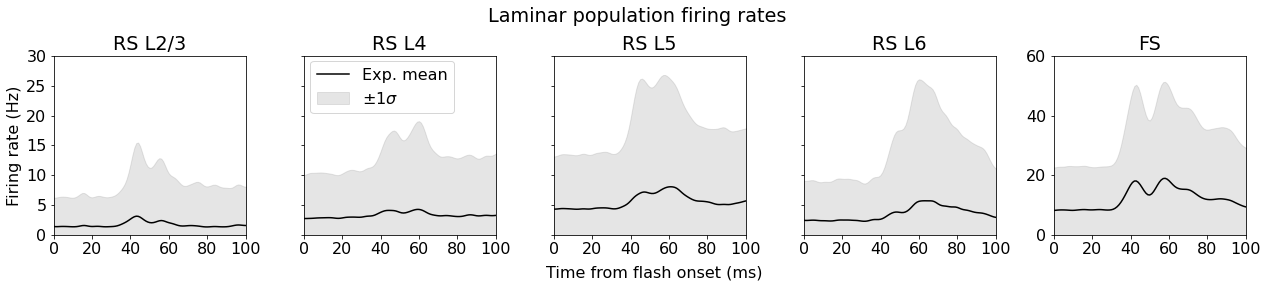

In [24]:
tstim_onset = 1000

fig, axes = plt.subplots(ncols = 5, figsize = (18,4))

fig.subplots_adjust(wspace = 0.3, left = 0.05, right = 0.97, bottom = 0.2, top = 0.82)

iplot = 0
for pop_name, all_spike_trains_pop in all_spike_trains_layer_pops.items():
    
    if iplot == 4:
        axes[iplot].set_ylim([0, 60])
    else:
        axes[iplot].set_ylim([0, 30])
        if iplot == 0:
            
            fir_rate_label = 'Exp. mean'
            std_label = '±1$\sigma$'
            
            axes[iplot].set_yticks(np.arange(0,30+5,5))
            axes[iplot].set_yticklabels(np.arange(0,30+5,5))
        else:
            fir_rate_label = None
            std_label = None
            axes[iplot].set_yticks(np.arange(0,30+5,5))
            axes[iplot].set_yticklabels([])
    
    pop_fir_rate = np.mean(np.mean(all_spike_trains_pop, axis = 0), axis = 0) * 1E3
    
    #all_spike_trains_pop_rs = all_spike_trains_pop.reshape(all_spike_trains_pop.shape[0]*\
    #                                                       all_spike_trains_pop.shape[1],-1)
    
    fir_rate_trial_avg = np.mean(all_spike_trains_pop, axis = 1)
    
    #std_time_resolved =  np.std(all_spike_trains_pop_rs, axis = 0)[tstim_onset:tstim_onset+100]*1E3
    
    std_of_trial_avg =  np.std(fir_rate_trial_avg, axis = 0)[tstim_onset:tstim_onset+105]*1E3
    
    std_of_trial_avg = gaussian_filter(std_of_trial_avg, sigma = 2)

    
    
    fir_rate_plot = gaussian_filter(pop_fir_rate, sigma = 2)[tstim_onset:tstim_onset+105]
    
    time = np.arange(0, 105, 1)
    
    axes[iplot].plot(time, fir_rate_plot, color = 'k', label = fir_rate_label)
    
    axes[iplot].fill_between(x = time, y1 = fir_rate_plot-std_of_trial_avg, \
                             y2 = fir_rate_plot+std_of_trial_avg, color = (0.5,0.5,0.5), 
                             alpha = 0.2, label = std_label)
    
    
            
    axes[iplot].set_xticks(np.arange(0,100+20,20))
    axes[iplot].set_xticklabels(np.arange(0,100+20,20))
    
    axes[iplot].set_xlim([0,100])
    
    axes[iplot].set_title(pop_name)
    iplot += 1
    
axes[0].set_ylabel('Firing rate (Hz)')

fig.suptitle('Laminar population firing rates', y = 0.99)
    
plt.figtext(s = 'Time from flash onset (ms)', x = 0.43, y = 0.05)
    
fig.legend(bbox_to_anchor = (0.365, 0.83))

fig_name = 'exp_pop_fir_rate.png'

savepath = os.path.join('Figures', 'Figure_2', fig_name)

#fig.savefig(savepath, facecolor = 'w')

# Quantify

### KS-similarity

- Compute KS-similarity between distribution of firing rates across cells in individual animals and distribution of firing rates across cells from all other animals.
- Note: This takes ~15 min. You can load the pre-computed KS-similarities for all animals in cells further below.

In [25]:
sessions_mode_ks_simil = dict()

In [ ]:
tstim_onset = 1000

for mode in ['baseline', 'peak', 'post-peak']:
    sessions_ks_simil = dict()

    if mode == 'peak':
        t_start = tstim_onset+35
        t_stop = tstim_onset+60
    elif mode == 'baseline':
        t_start = 250
        t_stop = tstim_onset
    elif mode == 'post-peak':
        t_start = tstim_onset+60
        t_stop = tstim_onset+100


    for session_id, spike_trains_layer_pops in sessions_spike_trains_layer_pops.items():

        ks_simil_pops = dict()
        for pop_name, spike_trains in spike_trains_layer_pops.items():
            ks_simil_pops[pop_name] = -1
            
            # criterion: 10 cells or more
            if len(spike_trains) < 10:
                continue

            all_spike_trains_except_sess = []
            for session_id2, spike_trains_layer_pops2 in sessions_spike_trains_layer_pops.items():
                spike_trains2 = spike_trains_layer_pops2[pop_name]
                if session_id2 == session_id or len(spike_trains2) == 0:
                    continue
                elif len(all_spike_trains_except_sess) == 0:
                    print(session_id, pop_name)
                    all_spike_trains_except_sess = spike_trains2
                else:
                    all_spike_trains_except_sess = np.concatenate([all_spike_trains_except_sess,
                                                                  spike_trains2])

            fir_rate_sess = np.mean(np.mean(spike_trains[:,:,t_start:t_stop], axis = -1), axis = -1)
            fir_rate_all_other_sess = np.mean(np.mean(all_spike_trains_except_sess[:,:,t_start:t_stop], axis = -1), axis = -1)

            ks_dist = stats.ks_2samp(fir_rate_all_other_sess, fir_rate_sess)[0]
            ks_simil_exp_temp = 1-ks_dist

            ks_simil_pops[pop_name] = ks_simil_exp_temp

        sessions_ks_simil[session_id] = ks_simil_pops
    sessions_mode_ks_simil[mode] = sessions_ks_simil

### Save KS-similarity data

In [ ]:
filename = 'exp_ks_simil_mode_w-RS-FS-naming.npy'
loadpath = os.path.join(exp_data_dir, 'spikes', 'V1', 'KS-similarity', filename)

In [ ]:
#np.save(savepath, sessions_mode_ks_simil)

### Load KS-similarity data

In [27]:
filename = 'exp_ks_simil_mode_w-RS-FS-naming.npy'
loadpath = os.path.join(exp_data_dir, 'spikes', 'V1', 'KS-similarity', filename)

sessions_mode_ks_simil = np.load(loadpath, allow_pickle = True)[()]

#### Reorganize by population instead of session (animal) for plotting

In [28]:
mode_ks_simil_all = dict()

for mode, sessions_ks_simil in sessions_mode_ks_simil.items():
    ks_simil_all = dict()
    ks_simil_all['RS L2/3'] = []
    ks_simil_all['RS L4'] = []
    ks_simil_all['RS L5'] = []
    ks_simil_all['RS L6'] = []
    ks_simil_all['FS'] = []

    for session_id, ks_simil_pops in sessions_ks_simil.items():

        for pop_name, ks_simil in ks_simil_pops.items():
            if ks_simil == -1:
                continue
            elif pop_name == 'E23':
                pop_name = 'E2/3'

            ks_simil_all[pop_name].append(ks_simil)
            
    mode_ks_simil_all[mode] = ks_simil_all

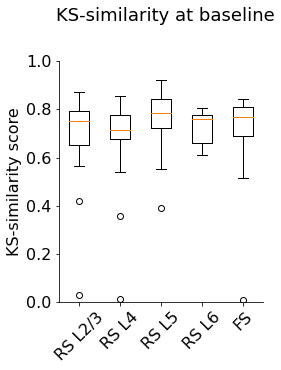

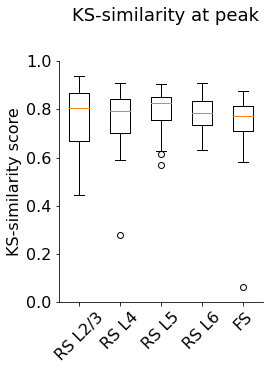

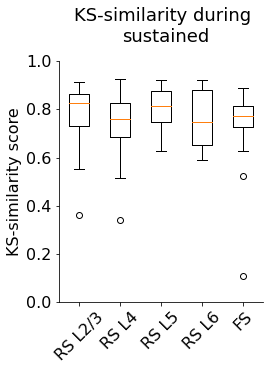

In [29]:
for mode in ['baseline', 'peak', 'post-peak']:
    fig, ax = plt.subplots(ncols = 1, figsize = (4,5), sharey = True)

    fig.subplots_adjust(wspace = 0.3, left = 0.21, right = 0.92, bottom = 0.17, top = 0.84)

    ks_simil_all = mode_ks_simil_all[mode]

    ipop = 0
    for pop_name, ks_simil_pop in ks_simil_all.items():
        ax.boxplot(ks_simil_pop, positions = [0.3*ipop])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        #axes[iplot].set_title(pop_name)

        ipop += 1

    ax.set_xticklabels(list(ks_simil_all.keys()), rotation = 45)

    ax.set_ylim([0.0, 1])
    ax.set_xlim([0-0.3/2,0.3*(ipop-1/2)])
    ax.set_ylabel('KS-similarity score')
    
    if mode == 'baseline':
        mode_title = 'at baseline'
    elif mode == 'peak':
        mode_title = 'at peak'
    elif mode == 'post-peak':
        mode_title = 'during \nsustained'

    fig.suptitle('KS-similarity '+mode_title, x = 0.58, y = 0.99, fontsize = 18)


    fig_name = 'KS-similarity-at-'+mode+'.png'
    savepath = os.path.join('Figures', 'Figure_2', fig_name)

    #fig.savefig(savepath, facecolor = 'w')

## Correlation

- Compute correlation between trial-averaged population firing rates in individual animals and trial-averaged population firing rates across cells from all other animals.
- Note: This takes ~15 min. You can load the pre-computed correlation for all animals in cells further below.

In [ ]:
sessions_corr_fir_rate = dict()

tstim_onset = 1000
t_start = tstim_onset
t_stop = tstim_onset+100
    

for session_id, spike_trains_layer_pops in sessions_spike_trains_layer_pops.items():
        
    corr_fir_rate_pops = dict()
    for pop_name, spike_trains in spike_trains_layer_pops.items():
        ks_simil_pops[pop_name] = -1
        
        # criterion: 10 cells or more
        if len(spike_trains) < 10:
            continue

        all_spike_trains_except_sess = []
        for session_id2, spike_trains_layer_pops2 in sessions_spike_trains_layer_pops.items():
            spike_trains2 = spike_trains_layer_pops2[pop_name]
            if session_id2 == session_id or len(spike_trains2) == 0:
                continue
            elif len(all_spike_trains_except_sess) == 0:
                print(session_id, pop_name)
                all_spike_trains_except_sess = spike_trains2
            else:
                all_spike_trains_except_sess = np.concatenate([all_spike_trains_except_sess,
                                                              spike_trains2])

        if ~np.any(spike_trains[:,:,t_start:t_stop]):
            continue
        fir_rate_sess = np.mean(np.mean(spike_trains[:,:,t_start:t_stop], axis = 0), axis = 0)
        fir_rate_all_other_sess = np.mean(np.mean(all_spike_trains_except_sess[:,:,t_start:t_stop], axis = 0), axis = 0)

        corr = stats.pearsonr(fir_rate_all_other_sess, fir_rate_sess)[0]

        corr_fir_rate_pops[pop_name] = corr

    sessions_corr_fir_rate[session_id] = corr_fir_rate_pops

### Save correlation data

In [38]:
filename = 'exp_corr_fir_rate-w-RS-FS-naming.npy'
loadpath = os.path.join(exp_data_dir, 'spikes', 'V1', 'correlation', filename)

In [39]:
#np.save(savepath, sessions_corr_fir_rate)

### Load correlation data

In [31]:
filename = 'exp_corr_fir_rate-w-RS-FS-naming.npy'
loadpath = os.path.join(exp_data_dir, 'spikes', 'V1', 'correlation', filename)

sessions_corr_fir_rate = np.load(loadpath, allow_pickle = True)[()]

#### Reorganize by population instead of session (animal) for plotting

In [32]:
corr_fir_rates_all = dict()
corr_fir_rates_all['RS L2/3'] = []
corr_fir_rates_all['RS L4'] = []
corr_fir_rates_all['RS L5'] = []
corr_fir_rates_all['RS L6'] = []
corr_fir_rates_all['FS'] = []

for session_id, corr_fir_rate_pops in sessions_corr_fir_rate.items():

    for pop_name, corr_fir_rates in corr_fir_rate_pops.items():
        if corr_fir_rates == -1:
            continue
        elif pop_name == 'E23':
            pop_name = 'E2/3'

        corr_fir_rates_all[pop_name].append(corr_fir_rates)

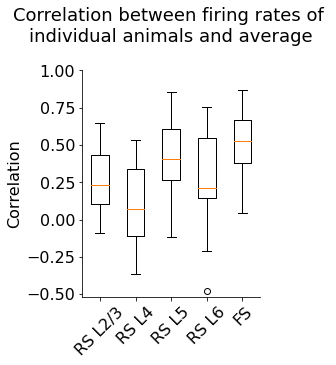

In [33]:
fig, ax = plt.subplots(ncols = 1, figsize = (4.5,5), sharey = True)

fig.subplots_adjust(left = 0.25, right = 0.8, bottom = 0.17, top = 0.8)

ipop = 0
for pop_name, corr_fir_rate_pop in corr_fir_rates_all.items():
    ax.boxplot(corr_fir_rate_pop, positions = [0.3*ipop])
    
    ipop+=1

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
ax.set_ylim([-.52, 1])
ax.set_ylabel('Correlation')

ax.set_title('Correlation between firing rates of \nindividual animals and average', x = 0.5, y = 1.1, fontsize = 18)

ax.set_xlim([0-0.3/2,0.3*(ipop-1/2)])

ax.set_xticklabels(list(corr_fir_rates_all.keys()), rotation = 45)
    
fig_name = 'Correlation-0-100ms.png'
savepath = os.path.join('Figures', 'Figure_2', fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Firing rates across cortical areas

In [34]:
sessions_spike_trains_all_VIS.keys()

dict_keys(['LGN', 'V1', 'LM', 'RL', 'AL', 'PM', 'AM'])

In [35]:
all_spike_trains_all_VIS = dict()

for structure_ in sessions_spike_trains_all_VIS.keys():
    all_spike_trains_all_VIS[structure_] = []

In [36]:
for structure_ in sessions_spike_trains_all_VIS.keys():
    for session_id in sessions_spike_trains_all_VIS[structure_]:
        spike_trains_structure = sessions_spike_trains_all_VIS[structure_][session_id]['exc']#\
                                    #[:, tstim_onset:tstim_onset+100]
        
        if len(spike_trains_structure) == 0:
            continue
        elif len(all_spike_trains_all_VIS[structure_]) == 0:
            all_spike_trains_all_VIS[structure_] = spike_trains_structure
        elif spike_trains_structure.shape[0] != all_spike_trains_all_VIS[structure_].shape[0]:
            continue
        else:
            all_spike_trains_all_VIS[structure_] = np.concatenate([all_spike_trains_all_VIS[structure_], \
                                                                  spike_trains_structure], axis = -1)

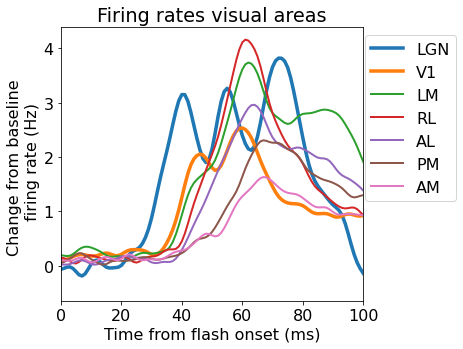

In [37]:
fig = plt.figure(figsize = (7,5))

ax = fig.add_subplot(1,1,1)

fig.subplots_adjust(left = 0.15, right = 0.75, bottom = 0.14, top = 0.9)

for structure_, all_spike_trains_structure in all_spike_trains_all_VIS.items():
    structure_fir_rate = np.mean(np.mean(all_spike_trains_structure, axis = 0), axis = -1)*1E3
    
    structure_fir_rate_plot = structure_fir_rate[tstim_onset:tstim_onset+105] - np.mean(structure_fir_rate[:tstim_onset])
    
    structure_fir_rate_plot = gaussian_filter(structure_fir_rate_plot, sigma = 2)
    

    if structure_ == 'V1' or structure_ == 'LGN':
        linewidth = 3.5
    else:
        linewidth = 2
    
    ax.plot(structure_fir_rate_plot, lw = linewidth, label = structure_)
    
ax.set_title('Firing rates visual areas')

ax.set_xlim([0,100])

ax.margins(x=0)

ax.set_ylabel('Change from baseline \n firing rate (Hz)')

ax.set_xlabel('Time from flash onset (ms)')
    
fig.legend(bbox_to_anchor = (0.95,0.9))

fig_name = 'fir_rates_vis_areas.png'

savepath = os.path.join('Figures', 'Figure_2', fig_name)

#fig.savefig(savepath)

### LFP and CSD

In [38]:

sessions_df_depth = dict()
loadpaths = sorted(glob(os.path.join(exp_meta_data_dir, 'probes_cortical_depths', '*')))
for loadpath in loadpaths:
    session_id = loadpath.split('/')[-1].split('.')[0].split('_')[-1]    
    df_depth = pd.read_csv(loadpath, sep=' ')
    df_depth = df_depth.set_index('id')
    sessions_df_depth[session_id] = df_depth


In [39]:
channel_step = 5
depth_ticks = np.arange(0, len(channels_vert_pos), channel_step)
depth_step = channel_step*np.diff(channels_vert_pos)[0]
depth_ticklabels = np.arange(channels_vert_pos[0], channels_vert_pos[-1]+depth_step, depth_step) 


time_start_label = 0
time_stop_label = 100
time_step_label = 20
time_ticklabels = np.arange(time_start_label, time_stop_label+time_step_label, time_step_label)
sf = 1250
time_tick_step = int(time_step_label*sf/1E3)
time_ticks = np.arange(0, sessions_csd_trial_avg[session_id].shape[-1]+time_tick_step, time_tick_step)

In [40]:
# example animals to plot
sel_session_ids = [766640955, 761418226, 754312389, 715093703, 719161530]
sel_session_ids_nrs = dict()

for isess, session_id in enumerate(sel_session_ids):
    sel_session_ids_nrs[session_id] = isess+1

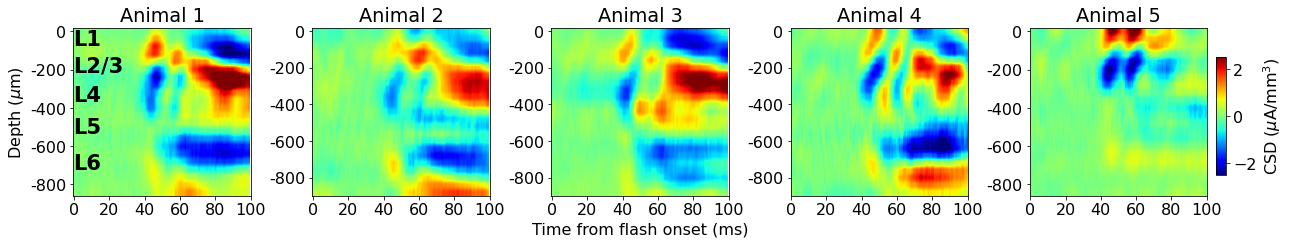

In [41]:
fig = plt.figure(figsize = (18.3,4.1))

scale_to_uA = 1E-3

for isess, session_id in enumerate(sel_session_ids):
    ax = fig.add_subplot(1,len(sel_session_ids),isess+1)
    
    csd_plot = sessions_csd_trial_avg[str(session_id)]*scale_to_uA
    
    if isess == 0:
        cmap_range = np.abs(csd_plot).max()/1.5
        ax.set_ylabel('Depth ($\mu$m)')
        
    im = ax.imshow(csd_plot, aspect = 'auto', cmap = 'jet', vmin = -cmap_range, vmax = cmap_range)
    ax.set_title('Animal '+str(sel_session_ids_nrs[session_id]))#str(session_id))
    
    ax.set_yticks(depth_ticks)
    ax.set_yticklabels(-np.arange(0,1000,200,dtype='int'))
    
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_ticklabels)
    
    if isess == 2:
        ax.set_xlabel('Time from flash onset (ms)')
    
fig.subplots_adjust(wspace = 0.35, left = 0.06, right = 0.92, bottom = 0.23, top = 0.80)

cbaxes = fig.add_axes([0.927,0.30,0.008, 0.4])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

#plt.figtext(x = 0.41, y = 0.09, s = 'Time from flash onset (ms)')

isess = 0
plt.figtext(x = 0.06, y = 0.74, s = 'L1', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.06, y = 0.65, s = 'L2/3', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.06, y = 0.55, s = 'L4', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.06, y = 0.44, s = 'L5', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.06, y = 0.32, s = 'L6', fontsize = 21, fontweight = 560)


fig_name = 'csd-inter-anim-variability-w-layer-labels.png'

savepath = os.path.join('Figures', 'Figure_2', fig_name)

#fig.savefig(savepath)

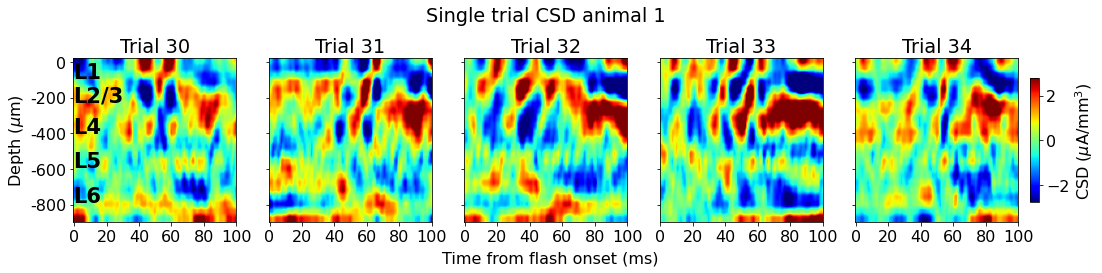

In [42]:
fig = plt.figure(figsize = (16,4))

scale_to_uA = 1E-3
csd_all_trials_plot = sessions_csd_all_trials[str(sel_session_ids[1])]*scale_to_uA
#csd_all_trials_plot = csd_all_trials_test

ntrials_to_plot = 5
start_trial_nr = 30

i_plot = 0
for itrial in range(start_trial_nr, start_trial_nr+ntrials_to_plot):
    ax = fig.add_subplot(1,ntrials_to_plot,i_plot+1)
    
    csd_plot = csd_all_trials_plot[:, itrial]
    
    csd_plot = gaussian_filter(csd_plot, sigma = (0, 1))
    
    if i_plot == 0:
        cmap_range = np.abs(csd_plot).max()/1.5
        ax.set_yticks(depth_ticks)
        ax.set_yticklabels(depth_ticklabels)
        ax.set_ylabel('Depth ($\mu$m)')
    else:
        ax.set_yticks(depth_ticks)
        ax.set_yticklabels([])
        
    im = ax.imshow(csd_plot, aspect = 'auto', cmap = 'jet', vmin = -cmap_range, vmax = cmap_range)
    
    ax.set_title('Trial '+str(itrial))
    
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_ticklabels)
        
    i_plot += 1
    
plt.figtext(x = 0.4, y = 0.09, s = 'Time from flash onset (ms)')
    
fig.subplots_adjust(wspace = 0.2, left = 0.08, right = 0.9, bottom = 0.23, top = 0.8)

cbaxes = fig.add_axes([0.91,0.30,0.008, 0.43])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

fig.suptitle('Single trial CSD animal '+str(sel_session_ids_nrs[sel_session_ids[0]]), x = 0.49)

isess = 0
plt.figtext(x = 0.08+isess*0.182, y = 0.73, s = 'L1', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.08+isess*0.182, y = 0.65, s = 'L2/3', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.08+isess*0.182, y = 0.54, s = 'L4', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.08+isess*0.182, y = 0.42, s = 'L5', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.08+isess*0.182, y = 0.3, s = 'L6', fontsize = 21, fontweight = 560)

fig_name = 'csd-inter-trial-variability-'+str(sel_session_ids[1])+'.png'

savepath = os.path.join('Figures', 'Figure_2', fig_name)

#fig.savefig(savepath)

## PCA on trial averaged CSD

### Interpolate and normalize

In [43]:
sessions_csd_trial_avg_interp = dict()
sessions_sinks_trial_avg_interp = dict()
sessions_sources_trial_avg_interp = dict()

sp_len = 30; t_len = 100
for i_sess, session_id in enumerate(sessions_csd_trial_avg_short.keys()):
    csd_trial_avg = sessions_csd_trial_avg_short[session_id]
    
    sinks_interp = np.zeros((sp_len, t_len))
    sources_interp = np.zeros((sp_len, t_len))
    
    z = csd_trial_avg
    
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)
    
    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0
    
    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])
    
    
    sessions_csd_trial_avg_interp[session_id] = csd_interp/np.abs(csd_interp).max()
    sessions_sinks_trial_avg_interp[session_id] = sinks_interp/sinks_interp.sum()
    sessions_sources_trial_avg_interp[session_id] = sources_interp/sources_interp.sum()

### Doing the PCA

In [44]:
csd_trial_avg_interp_grand = np.array(list(sessions_csd_trial_avg_interp.values()))
csd_trial_avg_interp_grand = csd_trial_avg_interp_grand.reshape(csd_trial_avg_interp_grand.shape[0], 
                        csd_trial_avg_interp_grand.shape[1]*csd_trial_avg_interp_grand.shape[2])

n_components = csd_trial_avg_interp_grand.shape[0]
pca = PCA(n_components=n_components)

pca.fit(csd_trial_avg_interp_grand.T)

PCA(n_components=44)

In [45]:
print(pca.explained_variance_ratio_)

[5.03910403e-01 1.38802335e-01 6.61447376e-02 5.30769109e-02
 3.32573348e-02 2.73709661e-02 2.26092151e-02 2.01221678e-02
 1.61550654e-02 1.30111692e-02 1.20868404e-02 1.03926962e-02
 9.41570153e-03 9.14499572e-03 6.42395357e-03 5.56246257e-03
 5.29747046e-03 4.34798311e-03 4.01254791e-03 3.89161973e-03
 3.56123120e-03 3.07196030e-03 2.93426248e-03 2.76032325e-03
 2.34272899e-03 2.23431932e-03 1.97779675e-03 1.81658373e-03
 1.61282564e-03 1.44059109e-03 1.35826902e-03 1.30787127e-03
 1.15977315e-03 1.09017860e-03 9.22867875e-04 8.02214636e-04
 7.85934912e-04 7.20523152e-04 6.29956384e-04 5.91210127e-04
 5.30757358e-04 4.64248098e-04 4.43407897e-04 4.03589006e-04]


#### Reshape components into CSD shape with (space, time) interpolated dimensions

In [46]:
# Look at first four components
recon = np.empty((4, sp_len, t_len))
for compNr in range(4):
    recon[compNr] = np.dot(pca.components_[compNr], csd_trial_avg_interp_grand).reshape(sp_len, t_len)*\
                        pca.explained_variance_ratio_[compNr]

In [47]:
# for plotting
plt.rcParams.update({'font.size': 18})

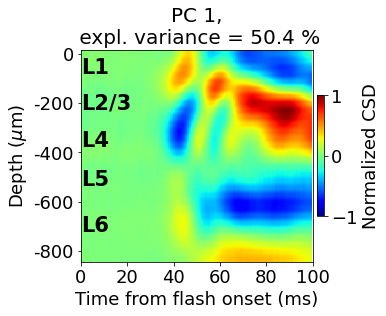

In [49]:
fig = plt.figure(figsize = (5.2,4.2))

fig.subplots_adjust(wspace = 0.2, left = 0.2, right = 0.82, bottom = 0.15, top = 0.85)

for compNr in range(1):
    
    ax = fig.add_subplot(1,1,compNr+1)
    
    
    cmap_range = np.abs(recon[compNr]/recon[compNr].max()).max()
    
    im = ax.imshow(recon[compNr]/recon[compNr].max(), cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    exp_var = np.round(pca.explained_variance_ratio_[compNr]*100,1)
    ax.set_title('PC '+str(compNr+1)+',\n expl. variance = '+str(exp_var)+' %', fontsize = 20)
    
    ax.set_xticks(np.arange(0,t_len+20, 20))
    ax.set_xlabel('Time from flash onset (ms)')
    #ax.margins(x=-0.01)
    ax.set_xlim([0,100])
        
    ax.set_yticks(np.arange(0,30,7))
    if compNr == 0:
        ax.set_yticklabels(-np.arange(0,1000,200))
        ax.set_ylabel('Depth ($\mu$m)')
    else:
        ax.set_yticklabels([])

    cbaxes = fig.add_axes([0.83,0.30,0.02, 0.4])
    cb = fig.colorbar(im, ax = ax, cax = cbaxes)
    cb.set_label('Normalized CSD', fontsize = 18)
    
    #plt.figtext(x = 0.06, y = 0.84, s = 'L1', fontsize = 21, fontweight = 560)
    isess = 0
    plt.figtext(x = 0.2, y = 0.77, s = 'L1', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.2, y = 0.655, s = 'L2/3', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.2, y = 0.53, s = 'L4', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.2, y = 0.4, s = 'L5', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.2, y = 0.25, s = 'L6', fontsize = 21, fontweight = 560)

    
    fig_name = 'CSD_of_PC1_w_depth_label.png'
    
    savepath = os.path.join('Figures', 'Figure_2', fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

### Split sources and sinks and do wasserstein distance calculation from trial-averaged CSD in individual animals to PC 1 CSD

In [50]:
recon_sinks_list = np.empty_like(recon)
recon_sources_list = np.empty_like(recon)

for compNr in range(recon.shape[0]):
    recon_temp = recon[compNr]
    mask_sinks = recon_temp < 0
    mask_sources = recon_temp > 0
    
    sinks_recon_temp = np.zeros_like(recon_temp)
    sinks_recon_temp[mask_sinks] = np.abs(recon_temp[mask_sinks])
    sources_recon_temp = np.zeros_like(recon_temp)
    sources_recon_temp[mask_sources] = np.abs(recon_temp[mask_sources])
    
    recon_sinks_list[compNr] = sinks_recon_temp/sinks_recon_temp.sum()
    recon_sources_list[compNr] = sources_recon_temp/sources_recon_temp.sum()

In [51]:
sinks_mice = np.array(list(sessions_sinks_trial_avg_interp.values()))
sources_mice = np.array(list(sessions_sources_trial_avg_interp.values()))

In [52]:
n_animals = len(sinks_mice)

#### Compute wasserstein distance

In [53]:
# for sinks
compNr = 0 # selecting PC 1 component
sink_matrix_recon_exp, M_sink_recon_exp, G0_sink_recon_exp, x_s, x_t = compute_dist_matrix_exp(sinks_mice[:n_animals], 
                                                                             recon_sinks_list[compNr:compNr+1],
                                                                            mode = 'exp_to_reco')

# for sources
source_matrix_recon_exp, M_source_recon_exp, G0_source_recon_exp, x_s, x_t = compute_dist_matrix_exp(sources_mice[:n_animals], 
                                                                             recon_sources_list[compNr:compNr+1],
                                                                            mode = 'exp_to_reco')

# sum wasserstein distances calculated for sinks and sources into one matrix of Wasserstein distances from 
# individual animals to PC 1 CSD
dist_matrix_recon_exp = sink_matrix_recon_exp+source_matrix_recon_exp

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:24<00:00,  1.77it/s]


#### Find indeces of example animals plotted earlier

In [54]:
# example animals to plot
sel_session_ids = [766640955, 761418226, 754312389, 715093703, 719161530]
sel_session_ids_nrs = dict()

for isess, session_id in enumerate(sel_session_ids):
    sel_session_ids_nrs[session_id] = isess+1

inds_sel_session_ids = dict()
for session_id in sel_session_ids:
    inds_sel_session_ids[str(session_id)] = np.where(np.array(list(sessions_sinks_trial_avg_interp.keys())) == str(session_id))[0][0]
    
inds_sel_session_ids

{'766640955': 18,
 '761418226': 15,
 '754312389': 6,
 '715093703': 0,
 '719161530': 1}

In [55]:
# for plotting
plt.rcParams.update({'font.size': 16})

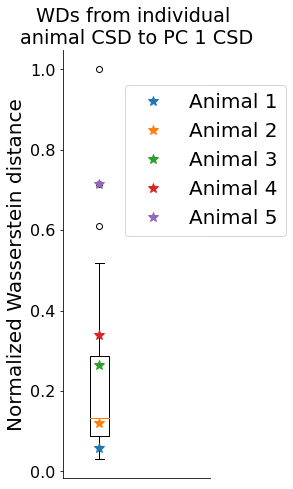

In [56]:
fig = plt.figure(figsize = (6,7))

ax = fig.add_subplot(1,1,1)

fig.subplots_adjust(left = 0.26, right = 0.6, bottom = 0.05, top = 0.9)

ax.boxplot(x = dist_matrix_recon_exp[:,compNr]/dist_matrix_recon_exp[:,compNr].max(), positions = [0.1], widths = [0.05])
#ax.boxplot(x = dist_matrix_recon_exp[:,compNr], positions = [0.1], widths = [0.05])


for session_id, idx in inds_sel_session_ids.items():
    ax.plot(0.1, dist_matrix_recon_exp[idx]/dist_matrix_recon_exp[:,compNr].max(), '*', markersize = 10, \
            label = 'Animal '+str(sel_session_ids_nrs[int(session_id)])) #label = session_id)
    #ax.plot(0.1, dist_matrix_recon_exp[idx], '*', markersize = 10, \
    #        label = 'Animal '+str(sel_session_ids_nrs[int(session_id)])) #label = session_id)


ax.set_xticks([])
ax.set_xlim([0,0.4])
ax.set_ylabel('Normalized Wasserstein distance', fontsize = 20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_ylabel('PDF')

fig.legend(bbox_to_anchor = (0.8,0.85), fontsize = 20)

ax.set_title('WDs from individual \nanimal CSD to PC 1 CSD')

fig_name = 'boxplot_WD_distr_animals_to_PC1_w_example_animals.png'

savepath = os.path.join('Figures', 'Figure_2', 'quantification', fig_name)

#fig.savefig(savepath, facecolor='w')

### Pairwise Wasserstein distance between trial averaged CSD of individual animals

- NB: This takes ~2 h to calculate and requires quite a bit of memory. You might want to decrease the resolution by changing the sp_len and t_len (number of points across depth and time, respectively) in the cell where the interpolation and normalization of trial-averaged CSD takes place. But make sure you retain the relative resolution in space vs. time.

In [55]:
sinks_mice = np.array(list(sessions_sinks_trial_avg_interp.values()))
sources_mice = np.array(list(sessions_sources_trial_avg_interp.values()))

In [56]:
# Pairwise WDs between sinks
sink_matrix_exp = compute_dist_matrix_exp(np.flip(sinks_mice, axis = 1), mode = 'pairwise_exp', return_G0 = False)

# Pairwise WDs between sources
source_matrix_exp = compute_dist_matrix_exp(np.flip(sources_mice, axis = 1), mode = 'pairwise_exp', return_G0 = False)

dist_matrix_exp = sink_matrix_exp + source_matrix_exp

sink_matrix_orig = sink_matrix_exp
source_matrix_orig = source_matrix_exp
dist_matrix_exp_orig = dist_matrix_exp

100%|██████████| 44/44 [10:43<00:00, 14.62s/it]


#### Rearrange pairwise Wasserstein distances to plot sorted by distance to PC 1 CSD

In [57]:
dist_matrix_exp_plot = []
for i in range(dist_matrix_exp.shape[0]):
    for j in range(dist_matrix_exp.shape[0]):
        if i <= j:
            continue
        else:
            dist_matrix_exp_plot.append(dist_matrix_exp[i,j])

dist_matrix_exp_plot = np.array(dist_matrix_exp_plot)
dist_matrix_exp_norm = dist_matrix_exp_plot/dist_matrix_exp_plot.max()
print((dist_matrix_exp_norm < 0.5).sum())

inds_dist_to_PC1_sort = np.argsort(dist_matrix_recon_exp[:,0])
dist_matrix_recon_exp[inds_dist_to_PC1_sort[0],0], dist_matrix_recon_exp[inds_dist_to_PC1_sort[-1],0]

session_ids_WD_to_PC1 = np.array(list(sessions_sinks_trial_avg_interp.keys()))[inds_dist_to_PC1_sort]

dist_matrix_exp_sorted = np.zeros((dist_matrix_exp.shape[0],dist_matrix_exp.shape[1]))

for i, irow in enumerate(inds_dist_to_PC1_sort):
    for j, icol in enumerate(inds_dist_to_PC1_sort):
        
        dist_matrix_exp_sorted[i,j] = dist_matrix_exp[irow,icol]
        
inds_sel_sessions_sort_PC1 = dict()

for session_id in sel_session_ids:
    inds_sel_sessions_sort_PC1[str(session_id)] = np.where(str(session_id) == session_ids_WD_to_PC1)[0][0]
    
inds_sel_sessions_sort_PC1_nrs = dict()

for animal_nr, session_id in enumerate(inds_sel_sessions_sort_PC1.keys()):
    inds_sel_sessions_sort_PC1_nrs['#'+str(animal_nr+1)] = inds_sel_sessions_sort_PC1[session_id]

921


#### Plot

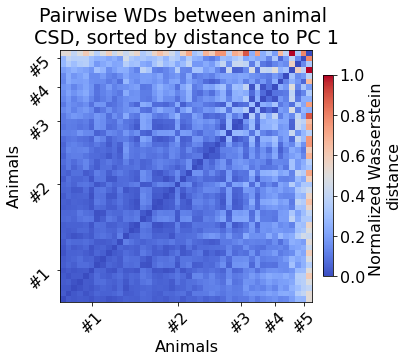

In [58]:
fig = plt.figure(figsize = (7,7))

ax = fig.add_subplot(1,1,1)
fig.subplots_adjust(left = 0.25, right = 0.75, bottom = 0.1, top = 0.9)
im = ax.imshow(dist_matrix_exp_sorted/dist_matrix_exp_sorted.max(), cmap = 'coolwarm', origin = 'bottom')
#ax.set_xticks(np.arange(len(session_ids_WD_to_PC1)))
#ax.set_xticklabels(session_ids_WD_to_PC1, rotation = 45)
ax.set_yticks(np.array(list(inds_sel_sessions_sort_PC1.values())))
#ax.set_yticklabels(np.array(list(inds_sel_sessions_sort_PC1.keys())), rotation =45)
ax.set_yticklabels(np.array(list(inds_sel_sessions_sort_PC1_nrs.keys())), rotation =45)
ax.set_xticks(np.array(list(inds_sel_sessions_sort_PC1.values())))
ax.set_xticklabels(np.array(list(inds_sel_sessions_sort_PC1_nrs.keys())), rotation =45)
ax.set_xlabel('Animals')
ax.set_ylabel('Animals')
cbaxes = fig.add_axes([0.77, 0.3, 0.02, 0.4])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('Normalized Wasserstein \ndistance')

ax.set_title('Pairwise WDs between animal \nCSD, sorted by distance to PC 1')

fig_name = 'WDgram-pairwise-sort-PC1.png'

savepath = os.path.join('Figures', 'Figure_2', 'quantification', fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Trial variability in CSD

#### Interpolate and normalize

- NB: Calculating the trial-to-trial WDs for all animals takes a long time (~15 h) and requires a lot of memory. You might want to decrease the resolution by changing the sp_len and t_len (number of points across depth and time, respectively) in the cell below where the interpolation and normalization of single trial CSD is carried out. But make sure you retain the relative resolution in space vs. time.
- Alternatively, you can load the pre-computed trial-to-trial WDs in the cell further below

In [69]:
sessions_csd_all_trials_interp = dict()
sessions_sinks_all_trials_interp = dict()
sessions_sources_all_trials_interp = dict()

sp_len = 18; t_len = 60
for i_sess, session_id in enumerate(sessions_csd_all_trials_short.keys()):
    csd_all_trials = sessions_csd_all_trials_short[session_id]
    
    sinks_interp = np.zeros((csd_all_trials.shape[1], sp_len, t_len))
    sources_interp = np.zeros((csd_all_trials.shape[1], sp_len, t_len))
    csd_interp_all_trials = np.zeros((csd_all_trials.shape[1], sp_len, t_len))
    
    for itrial in range(csd_all_trials.shape[1]):

        z = csd_all_trials[:,itrial]
        x = np.linspace(0., 1., z.shape[1], endpoint=True)
        y = np.linspace(0., 1., z.shape[0], endpoint=True)
        #xx, yy = np.meshgrid(x, y)
        f = interpolate.interp2d(x, y, z, kind='cubic')

        x_new = np.linspace(0., 1., t_len, endpoint=True)
        y_new = np.linspace(0., 1., sp_len, endpoint=True)
        csd_interp = f(x_new, y_new)
        csd_interp_all_trials[itrial] = csd_interp
    
        mask_sinks = csd_interp < 0
        mask_sources = csd_interp > 0
    
        sinks_interp[itrial, mask_sinks] = np.abs(csd_interp[mask_sinks])
        sources_interp[itrial, mask_sources] = np.abs(csd_interp[mask_sources])
        
        sinks_interp[itrial] = sinks_interp[itrial]/sinks_interp[itrial].sum()
        sources_interp[itrial] = sources_interp[itrial]/sources_interp[itrial].sum()
    
    if ~np.any(np.isnan(csd_interp_all_trials)):
        sessions_csd_all_trials_interp[session_id] = csd_interp_all_trials/np.abs(csd_interp_all_trials).max()
        sessions_sinks_all_trials_interp[session_id] = sinks_interp#/sinks_interp.sum()
        sessions_sources_all_trials_interp[session_id] = sources_interp#/sources_interp.sum()
    else:
        print(session_id)

#### Pairwise distance between trials

In [70]:
sessions_dist_matrix_alltr_exp = dict()

In [71]:
for session_id in list(sessions_sinks_all_trials_interp.keys()):
    print(session_id)
    
    sinks_mouse = sessions_sinks_all_trials_interp[session_id]
    sources_mouse = sessions_sources_all_trials_interp[session_id]
    
    sink_matrix_alltr_exp = compute_dist_matrix_exp(sinks_mouse, mode = 'pairwise_exp')
    source_matrix_alltr_exp = compute_dist_matrix_exp(sources_mouse, mode = 'pairwise_exp')
    
    dist_matrix_alltr_exp = sink_matrix_alltr_exp + source_matrix_alltr_exp
    
    dist_matrix_alltr_exp_plot = []
    for i in range(dist_matrix_alltr_exp.shape[0]):
        for j in range(dist_matrix_alltr_exp.shape[0]):
            if i <= j:
                continue
            else:
                dist_matrix_alltr_exp_plot.append(dist_matrix_alltr_exp[i,j])
                
    sessions_dist_matrix_alltr_exp[session_id] = dist_matrix_alltr_exp_plot

  0%|          | 0/75 [00:00<?, ?it/s]

715093703


  0%|          | 0/75 [00:00<?, ?it/s]

719161530


  0%|          | 0/75 [00:00<?, ?it/s]

721123822


  0%|          | 0/75 [00:00<?, ?it/s]

744228101


  0%|          | 0/75 [00:00<?, ?it/s]

750749662


  0%|          | 0/75 [00:00<?, ?it/s]

751348571


  0%|          | 0/75 [00:00<?, ?it/s]

754312389


  0%|          | 0/75 [00:00<?, ?it/s]

754829445


  0%|          | 0/75 [00:00<?, ?it/s]

755434585


  0%|          | 0/75 [00:00<?, ?it/s]

756029989


  0%|          | 0/75 [00:00<?, ?it/s]

757216464


  0%|          | 0/75 [00:00<?, ?it/s]

757970808


  0%|          | 0/75 [00:00<?, ?it/s]

758798717


  0%|          | 0/75 [00:00<?, ?it/s]

759883607


  0%|          | 0/75 [00:00<?, ?it/s]

760345702


  0%|          | 0/75 [00:00<?, ?it/s]

761418226


  0%|          | 0/75 [00:00<?, ?it/s]

762602078


  0%|          | 0/75 [00:00<?, ?it/s]

763673393


  0%|          | 0/75 [00:00<?, ?it/s]

766640955


  0%|          | 0/75 [00:00<?, ?it/s]

767871931


  0%|          | 0/75 [00:00<?, ?it/s]

768515987


  0%|          | 0/75 [00:00<?, ?it/s]

771160300


  0%|          | 0/75 [00:00<?, ?it/s]

771990200


  0%|          | 0/75 [00:00<?, ?it/s]

773418906


  0%|          | 0/75 [00:00<?, ?it/s]

774875821


  0%|          | 0/75 [00:00<?, ?it/s]

778240327


  0%|          | 0/75 [00:00<?, ?it/s]

778998620


  0%|          | 0/75 [00:00<?, ?it/s]

779839471


  0%|          | 0/75 [00:00<?, ?it/s]

781842082


  0%|          | 0/75 [00:00<?, ?it/s]

786091066


  0%|          | 0/75 [00:00<?, ?it/s]

787025148


  0%|          | 0/75 [00:00<?, ?it/s]

789848216


  0%|          | 0/75 [00:00<?, ?it/s]

791319847


  0%|          | 0/75 [00:00<?, ?it/s]

793224716


  0%|          | 0/75 [00:00<?, ?it/s]

794812542


  0%|          | 0/75 [00:00<?, ?it/s]

797828357


  0%|          | 0/75 [00:00<?, ?it/s]

798911424


  0%|          | 0/75 [00:00<?, ?it/s]

799864342


  0%|          | 0/75 [00:00<?, ?it/s]

816200189


  0%|          | 0/75 [00:00<?, ?it/s]

829720705


  0%|          | 0/75 [00:00<?, ?it/s]

831882777


  0%|          | 0/75 [00:00<?, ?it/s]

835479236


  0%|          | 0/75 [00:00<?, ?it/s]

839068429


  0%|          | 0/75 [00:00<?, ?it/s]

840012044


100%|██████████| 75/75 [00:40<00:00,  1.87it/s]


### Load pre-computed trial-to-trial WDs

In [57]:
filename = 'pairwise_WD_trials_all_sessions.npy'
sessions_dist_matrix_alltr_exp = np.load(filename, allow_pickle = True)[()]

#### Compute pairwise distances between trial-averaged CSD of animals to compare the inter-trial and inter-animal variability

In [58]:
sessions_csd_trial_avg_interp = dict()
sessions_sinks_trial_avg_interp = dict()
sessions_sources_trial_avg_interp = dict()

sp_len = 21; t_len = 70
for i_sess, session_id in enumerate(sessions_csd_trial_avg_short.keys()):
    csd_trial_avg = sessions_csd_trial_avg_short[session_id]
    
    sinks_interp = np.zeros((sp_len, t_len))
    sources_interp = np.zeros((sp_len, t_len))
    
    z = csd_trial_avg
    
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)
    
    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0
    
    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])
    
    
    sessions_csd_trial_avg_interp[session_id] = csd_interp/np.abs(csd_interp).max()
    sessions_sinks_trial_avg_interp[session_id] = sinks_interp/sinks_interp.sum()
    sessions_sources_trial_avg_interp[session_id] = sources_interp/sources_interp.sum()

In [59]:
sinks_mice = np.array(list(sessions_sinks_trial_avg_interp.values()))
sources_mice = np.array(list(sessions_sources_trial_avg_interp.values()))

In [60]:
# Pairwise WDs between sinks
sink_matrix_exp = compute_dist_matrix_exp(np.flip(sinks_mice, axis = 1), mode = 'pairwise_exp', return_G0 = False)

# Pairwise WDs between sources
source_matrix_exp = compute_dist_matrix_exp(np.flip(sources_mice, axis = 1), mode = 'pairwise_exp', return_G0 = False)

dist_matrix_exp = sink_matrix_exp + source_matrix_exp

sink_matrix_orig = sink_matrix_exp
source_matrix_orig = source_matrix_exp
dist_matrix_exp_orig = dist_matrix_exp

dist_matrix_exp_plot = []
for i in range(dist_matrix_exp.shape[0]):
    for j in range(dist_matrix_exp.shape[0]):
        if i <= j:
            continue
        else:
            dist_matrix_exp_plot.append(dist_matrix_exp[i,j])

dist_matrix_exp_plot = np.array(dist_matrix_exp_plot)
dist_matrix_exp_norm = dist_matrix_exp_plot/dist_matrix_exp_plot.max()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [02:16<00:00,  3.11s/it]


#### Normalize to greatest pairwise distance between trial-averaged CSD of individual animals

In [61]:
pwise_WD_animals_max = dist_matrix_exp.max()
dist_mat_alltr_plot = list(sessions_dist_matrix_alltr_exp.values())
dist_mat_alltr_plot = np.array(list(sessions_dist_matrix_alltr_exp.values()))
dist_mat_alltr_plot /= pwise_WD_animals_max
dist_mat_alltr_plot = list(dist_mat_alltr_plot)
np.shape(dist_mat_alltr_plot)

(44, 2775)

#### Plot comparison of cumulative distributions for supplementary figures

In [62]:
hitmonchan = ['#0f0f0f', '#ccb37a', '#a38a72', '#c4b3c4', '#59400f', '#bc3049', '#edd49b', '#a39ba3', '#614972', '#e56149', '#8a1f00', '#fe9359', '#fef5fe', '#ddccdd']
magneton = ['#383030', '#0f0f0f', '#8ab3a3', '#d4f5dd', '#514949', '#fefefe', '#8a8a8a', '#598261', '#b3d4bc', '#fe8a49', '#51ccf5', '#ed1700', '#2882ab', '#b3b3b3', '#d4d4d4']

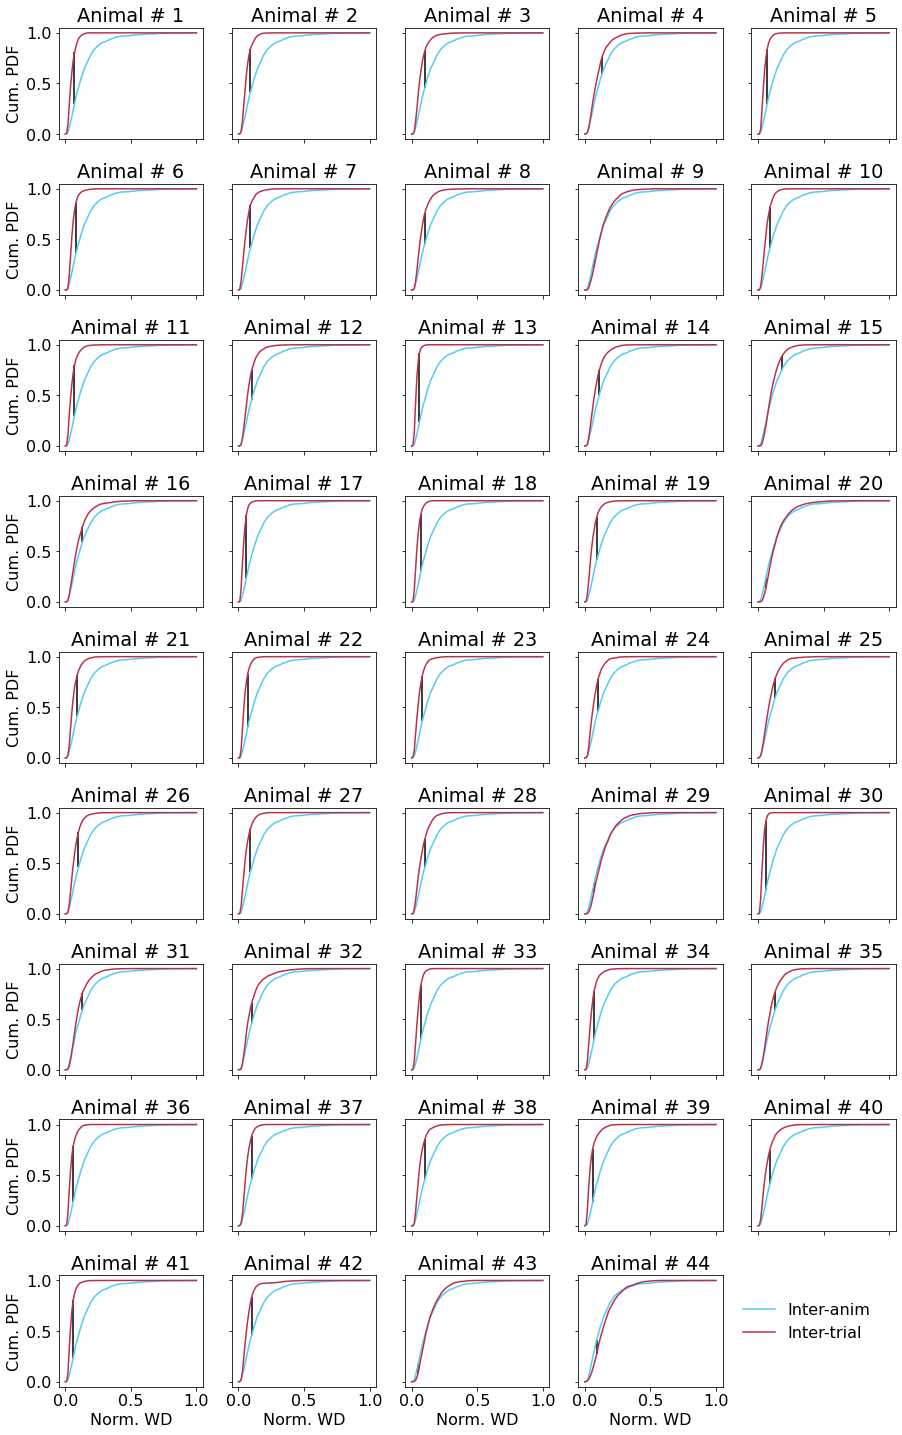

In [63]:
bins = np.linspace(0, dist_matrix_exp_norm.max(), 101)
dist_matrix_exp_norm_hist = np.histogram(dist_matrix_exp_norm, bins = bins)[0]

dist_matrix_exp_norm_cumsum = np.cumsum(dist_matrix_exp_norm_hist)

x0 = np.linspace(0,1, len(dist_matrix_exp_norm_cumsum))

fig, axes = plt.subplots(nrows = 9, ncols = 5, figsize = (15, 25), sharey=True, sharex = True)

fig.subplots_adjust(hspace = 0.4)

iplot = 0
for ianim in range(np.shape(dist_mat_alltr_plot)[0]):
    irow = iplot // 5
    icol = iplot %5
    
    ax = axes[irow, icol]
    
    if iplot == 0:
        label_trial = 'Inter-trial'
        label_anim = 'Inter-anim'
    else:
        label_trial = None
        label_anim = None
    
    #ax.plot(x0, dist_matrix_exp_norm_cumsum/dist_matrix_exp_norm_cumsum.max())
    cumsum_anim_var = np.cumsum(dist_matrix_exp_norm_hist)/np.cumsum(dist_matrix_exp_norm_hist).max()
    ax.plot(x0, cumsum_anim_var, label = label_anim, color = magneton[10])
    
    bins_ianim = np.linspace(0, dist_mat_alltr_plot[ianim].max(), 101)
    dist_mat_alltr_plot_hist = np.histogram(dist_mat_alltr_plot[ianim], bins = bins)[0]
    
    cumsum_trial_var = np.cumsum(dist_mat_alltr_plot_hist)/np.cumsum(dist_mat_alltr_plot_hist).max()
    
    x1 = np.linspace(0,1, len(cumsum_trial_var))
    
    #ax.plot(x1, dist_mat_alltr_cumsum/dist_mat_alltr_cumsum.max())
    
    ax.plot(x1, cumsum_trial_var, label = label_trial, color = hitmonchan[5])
    
    
    diff_cumsum = cumsum_trial_var-cumsum_anim_var
    diff_cumsum_abs = np.abs(diff_cumsum)
    idx_max_diff_cumsum = np.argmax(diff_cumsum_abs)
    max_diff_cumsum = np.max(diff_cumsum_abs)
    ax.vlines(bins[idx_max_diff_cumsum], cumsum_trial_var[idx_max_diff_cumsum], cumsum_anim_var[idx_max_diff_cumsum], 'k')

    
    
    ax.set_title(iplot+1)
    
    ax.set_title('Animal # '+str(iplot+1))
    
    if icol == 0:
        ax.set_ylabel('Cum. PDF')
        
    if irow == 8:
        ax.set_xlabel('Norm. WD')
    
    iplot += 1
    
fig.delaxes(axes[irow,icol+1])
    
fig.legend(bbox_to_anchor = (0.89,0.18),frameon = False)

fig_name = 'cum-pdf-trial-vs-anim-var-WD-all-anims.png'

savepath = os.path.join('Figures', 'Supplementary_figures', fig_name)

#fig.savefig(savepath, facecolor = 'w')

In [64]:
stats_pwise_WD = dict()

stats_pwise_WD['k'] = []
stats_pwise_WD['p-k'] = []
stats_pwise_WD['trial-var-greater'] = []


bins = np.linspace(0, dist_matrix_exp_norm.max(), 101)

for ianim in range(np.shape(dist_mat_alltr_plot)[0]):
    k, p_k = scipy.stats.ks_2samp(dist_mat_alltr_plot[ianim], dist_matrix_exp_norm)
    t, p_t = scipy.stats.ttest_ind(dist_mat_alltr_plot[ianim], dist_matrix_exp_norm)
    
    dist_mat_alltr_plot_hist = np.histogram(dist_mat_alltr_plot[ianim], bins = bins)[0]
    cumsum_anim_var = np.cumsum(dist_matrix_exp_norm_hist)/np.cumsum(dist_matrix_exp_norm_hist).max()
    cumsum_trial_var = np.cumsum(dist_mat_alltr_plot_hist)/np.cumsum(dist_mat_alltr_plot_hist).max()
    
    diff_cumsum = cumsum_trial_var-cumsum_anim_var
    diff_cumsum_abs = np.abs(diff_cumsum)
    idx_max_diff_cumsum = np.argmax(diff_cumsum_abs)
    max_diff_cumsum = np.max(diff_cumsum_abs)

    if diff_cumsum[idx_max_diff_cumsum] < 0:
        trial_var_greater = True
    else:
        trial_var_greater = False
        
    k = np.round(k, 2)
    p_k = np.round(p_k, 4)

    stats_pwise_WD['k'].append(k)
    stats_pwise_WD['p-k'].append(p_k)
    stats_pwise_WD['trial-var-greater'].append(trial_var_greater)

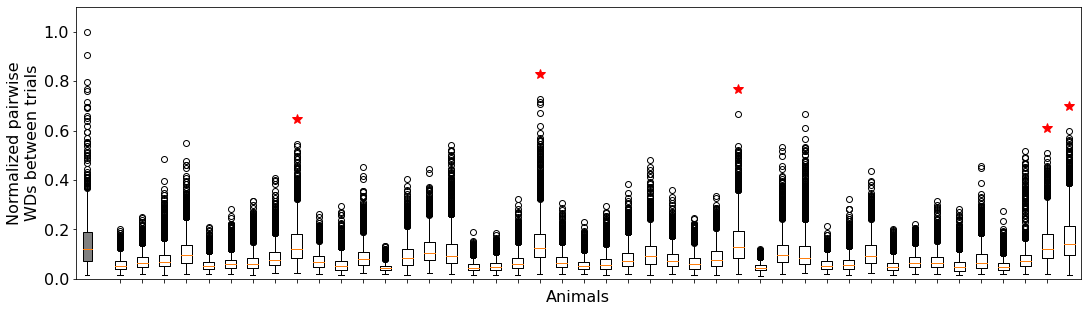

In [65]:
fig = plt.figure(figsize = (18,5))

ax = fig.add_subplot(1,1,1)

ax.boxplot(x = dist_matrix_exp_norm, positions = [-0.5], widths = [0.4], patch_artist = True, \
                         boxprops=dict(facecolor="grey"))

#ax.violinplot(dist_matrix_exp_norm, positions = [-0.5])

#dist_mat_alltr_plot = list(sessions_dist_matrix_alltr_exp.values())
dist_mat_alltr_plot = np.array(list(sessions_dist_matrix_alltr_exp.values()))
dist_mat_alltr_plot /= np.array(dist_matrix_exp).max()
dist_mat_alltr_plot = list(dist_mat_alltr_plot)
#dist_mat_alltr_plot = dist_mat_alltr_plot.flatten()

ax.boxplot(x = dist_mat_alltr_plot);#, positions = np.arange(len(dist_mat_alltr_plot)))#, widths = [0.05]*len(dist_mat_alltr_plot))
#ax.violinplot(dist_mat_alltr_plot)
#ax.boxplot(np.array(dist_matrix_exp_norm), positions = [0])
#ax.hlines(y = 1.0, xmin = 0, xmax = len(dist_mat_alltr_plot), linestyle = '--')

ax.set_xlim([-1, len(dist_mat_alltr_plot)+.5])

ax.set_ylim([0, 1.1])

#ax.set_xticklabels([])
ax.set_xlabel('Animals')
ax.set_ylabel('Normalized pairwise\nWDs between trials')

#ax.set_title('Pairwise WDs between trials in each animal')

ax.set_xticks(np.arange(1,len(dist_mat_alltr_plot)))
ax.set_xticklabels([])
#ax.set_xticklabels(np.array(list(inds_sel_session_ids.keys())), rotation = '45')

for i in np.where(np.array(stats_pwise_WD['trial-var-greater']))[0]:
    #print(i+1)
    ax.plot(i+1, np.max(dist_mat_alltr_plot[i])+0.1, '*', markersize = 11, color = 'r')
    

fig_name = 'WD-pairwise-trials-all-mice.png'

savepath = os.path.join('Figures', 'Figure_2', fig_name)

#fig.savefig(savepath, facecolor = 'w')

0.3277357484334229 2.5096047539612623e-90


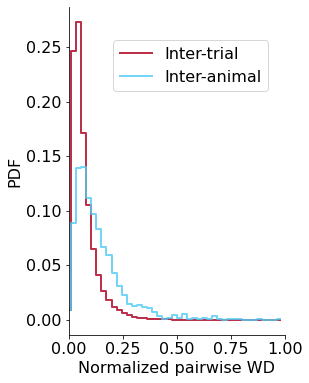

In [66]:
fig = plt.figure(figsize = (6,7))

ax = fig.add_subplot(1,1,1)

fig.subplots_adjust(left = 0.2, right = 0.7, bottom = 0.15, top = 0.8)

#ax.boxplot(dist_matrix_recon_exp[:,compNr])
#bins = np.linspace(0, dist_matrix_recon_exp[:,compNr].max(), len(dist_matrix_recon_exp[:,compNr]))
#ax.step(x = bins, y = dist_matrix_recon_exp[:,compNr])
dist_matrix_alltrials = np.array(list(sessions_dist_matrix_alltr_exp.values())).flatten()

#bins = np.linspace(0, dist_matrix_alltrials.max(), len(dist_matrix_alltrials))
bins = np.linspace(0, np.array(dist_matrix_exp_plot).max(), len(sessions_dist_matrix_alltr_exp))
hist = np.histogram(dist_matrix_alltrials, bins = bins)[0]
hist = hist/hist.sum()
ax.step(x = bins[:-1]/bins.max(), y = hist, where = 'mid', lw = 2, color = hitmonchan[5], label = 'Inter-trial')


bins = np.linspace(0, np.array(dist_matrix_exp_plot).max(), len(sessions_sinks_trial_avg_interp.keys()))
hist = np.histogram(np.array(dist_matrix_exp_plot), bins = bins)[0]
hist = hist/hist.sum()
ax.step(x = bins[:-1]/bins.max(), y = hist, where = 'mid', lw = 2, color = magneton[10], alpha = 0.8, label = 'Inter-animal')


ks_dist, p = stats.ks_2samp(np.array(dist_matrix_exp_plot), dist_matrix_alltrials)
print(ks_dist, p)

ax.set_xlim([0, 1.0])

#ax.hist(dist_matrix_recon_exp[:,compNr], bins = bins, histtype=u'step', density=True)

#ax.plot(1, dist_matrix_recon_sim[0,0], 'o', label = sim_understandable_names[sim_names[0]])
#ax.plot(1, dist_matrix_recon_sim[0,1], 'o', label = sim_understandable_names[sim_names[1]])

#ax.set_xticklabels([])
ax.set_xlabel('Normalized pairwise WD')
#ax.set_title('Pairwise WD between single trial CSDs within animals and trial-avg. CSD across animals')
ax.set_ylabel('PDF')
ax.margins(x=0)

fig.legend(bbox_to_anchor = (0.68,0.75))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax.set_title('Wasserstein distances to PC1')

fig_name = 'WD_inter-trial-and-inter-animal-var.png'

savepath = os.path.join('Figures', 'Figure_2', 'quantification', fig_name)

#fig.savefig(savepath, facecolor='w')

### Illustrate Wasserstein distance between animal CSD

In [93]:
sessions_csd_trial_avg_interp = dict()
sessions_sinks_trial_avg_interp = dict()
sessions_sources_trial_avg_interp = dict()

sp_len = 30; t_len = 100
#sp_len = 50; t_len = 50
#sp_len = 27; t_len = 90
#sp_len = 24; t_len = 80
#sp_len = 18; t_len = 60
for i_sess, session_id in enumerate(sel_session_ids):
    csd_trial_avg = sessions_csd_trial_avg_short[str(session_id)]
    
    sinks_interp = np.zeros((sp_len, t_len))
    sources_interp = np.zeros((sp_len, t_len))
    
    z = csd_trial_avg
    
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)
    
    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0
    
    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])
    
    
    sessions_csd_trial_avg_interp[session_id] = csd_interp/np.abs(csd_interp).max()
    sessions_sinks_trial_avg_interp[session_id] = sinks_interp/sinks_interp.sum()
    sessions_sources_trial_avg_interp[session_id] = sources_interp/sources_interp.sum()
    
    
sinks_mice = np.array(list(sessions_sinks_trial_avg_interp.values()))
sources_mice = np.array(list(sessions_sources_trial_avg_interp.values()))

# Pairwise WDs between sinks
sink_matrix_exp = compute_dist_matrix_exp(np.flip(sinks_mice, axis = 1), mode = 'pairwise_exp', return_G0=False)

# Pairwise WDs between sources
source_matrix_exp = compute_dist_matrix_exp(np.flip(sources_mice, axis = 1), mode = 'pairwise_exp', return_G0=False)

dist_matrix_exp = sink_matrix_exp + source_matrix_exp


'''-------------------------------------------------------------------------'''

sessions_csd_trial_avg_interp = dict()
sessions_sinks_trial_avg_interp = dict()
sessions_sources_trial_avg_interp = dict()

# sp_len and t_len are only set to these values for visualization purposes
sp_len = 50; t_len = 50
for i_sess, session_id in enumerate(sel_session_ids):
    csd_trial_avg = sessions_csd_trial_avg_short[str(session_id)]
    
    sinks_interp = np.zeros((sp_len, t_len))
    sources_interp = np.zeros((sp_len, t_len))
    
    z = csd_trial_avg
    
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)
    
    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0
    
    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])
    
    
    sessions_csd_trial_avg_interp[session_id] = csd_interp/np.abs(csd_interp).max()
    sessions_sinks_trial_avg_interp[session_id] = sinks_interp/sinks_interp.sum()
    sessions_sources_trial_avg_interp[session_id] = sources_interp/sources_interp.sum()
    
    
sinks_mice = np.array(list(sessions_sinks_trial_avg_interp.values()))
sources_mice = np.array(list(sessions_sources_trial_avg_interp.values()))

# Pairwise WDs between sinks
do_not_use, M_sink_exp, G0_sink_exp, x_s, x_t = compute_dist_matrix_exp(np.flip(sinks_mice, axis = 1), mode = 'pairwise_exp', return_G0=True)

# Pairwise WDs between sources
do_not_use, M_source_exp, G0_source_exp, x_s, x_t = compute_dist_matrix_exp(np.flip(sources_mice, axis = 1), mode = 'pairwise_exp', return_G0=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.11s/it]


exp_nr1:  0
exp_nr2:  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 828.98it/s]


exp_nr1:  4
exp_nr2:  0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 851.97it/s]


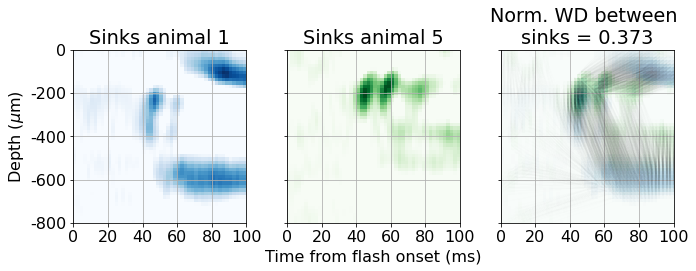

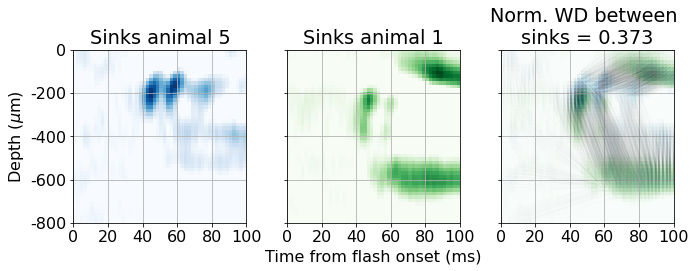

In [94]:
for session_id1 in sel_session_ids[0::4]:
    for session_id2 in sel_session_ids[0::4]:
        if session_id1 == session_id2:
            continue
            
        exp_nr1 = np.where(session_id1 == np.array(sel_session_ids))[0][0]
        exp_nr2 = np.where(session_id2 == np.array(sel_session_ids))[0][0]
        print('exp_nr1: ', exp_nr1)
        print('exp_nr2: ', exp_nr2)
        #print('exp_nr1 + exp_nr2: ', exp_nr1+exp_nr2)

        sink_exp1 = sessions_sinks_trial_avg_interp[session_id1]
        sink_exp2 = sessions_sinks_trial_avg_interp[session_id2]
        
        fig = plot_wasserstein_result(sink_exp1,sink_exp2,G0_sink_exp[exp_nr1][exp_nr2],x_s,x_t, \
                                      str(sel_session_ids_nrs[session_id1]), str(sel_session_ids_nrs[session_id2]),\
                                      'sink', M_sink_exp, dist = sink_matrix_exp[exp_nr1, exp_nr2]/dist_matrix_recon_exp[:,compNr].max())
        
        fig.subplots_adjust(wspace = 0.001, left = 0.1, right = 0.99, bottom = 0.2, top = 0.8)
        
        #fig.legend()
        
        if session_id1 != session_id2:
        
            fig_name = 'WD-sink-illustration-'+str(session_id1)+'-to-'+str(session_id2)+'.png'

            savepath = os.path.join('Figures', 'Figure_2', fig_name)

            #fig.savefig(savepath, facecolor = 'w')

exp_nr1:  0
exp_nr2:  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 807.43it/s]


exp_nr1:  4
exp_nr2:  0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 709.50it/s]


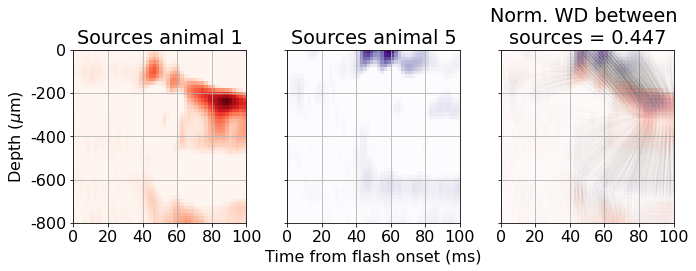

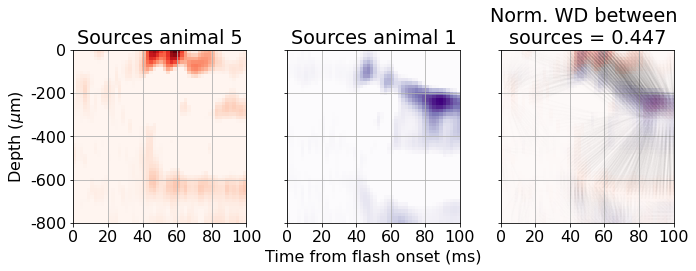

In [95]:
for session_id1 in sel_session_ids[0::4]:
    for session_id2 in sel_session_ids[0::4]:
        if session_id1 == session_id2:
            continue
            
        exp_nr1 = np.where(session_id1 == np.array(sel_session_ids))[0][0]
        exp_nr2 = np.where(session_id2 == np.array(sel_session_ids))[0][0]
        print('exp_nr1: ', exp_nr1)
        print('exp_nr2: ', exp_nr2)
        #print('exp_nr1 + exp_nr2: ', exp_nr1+exp_nr2)

        source_exp1 = sessions_sources_trial_avg_interp[session_id1]
        source_exp2 = sessions_sources_trial_avg_interp[session_id2]
        
        fig = plot_wasserstein_result(source_exp1,source_exp2,G0_source_exp[exp_nr1][exp_nr2],x_s,x_t, \
                                      str(sel_session_ids_nrs[session_id1]), str(sel_session_ids_nrs[session_id2]),'source', M_source_exp,
                                     dist = source_matrix_orig[exp_nr1, exp_nr2]/dist_matrix_recon_exp[:,compNr].max())
        
        fig.subplots_adjust(wspace = 0.001, left = 0.1, right = 0.99, bottom = 0.2, top = 0.8)
        if session_id1 != session_id2:
        
            fig_name = 'WD-source-illustration-'+str(session_id1)+'-to-'+str(session_id2)+'.png'

            savepath = os.path.join('Figures', 'Figure_2', fig_name)

            #fig.savefig(savepath, facecolor = 'w')